In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

import numpy as np
import pandas as pd
import sqlalchemy as sqa

from jax.random import PRNGKey
import jax.numpy as jnp
from jax import random

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, log_likelihood

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import scenario_generator.utils as u
import cel_utils.disk_utils as du

import gas_models

In [4]:
save_dir = os.path.join(os.environ['HOME'], 'Documents', 'direct_filp_v3')
offline_dir = os.path.join(save_dir, 'offline')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_dir, exist_ok=True)

In [5]:
training_start_date = date(2022, 12, 1)  # this corresponds to the date that FIP45 was passed, which changed how much gas PSD messages took
training_end_date = date.today()-timedelta(days=3)

full_df = gas_models.get_training_data(training_start_date, training_end_date)

# train/test split
n_samp = len(full_df)
n_train = int(n_samp * 0.7)

train_df = full_df.iloc[0:n_train]
test_df = full_df.iloc[n_train:]

num_mc = 500

In [6]:
full_df.head()

,stat_date,total_gas_used,provecommit_sector_gas_used,precommit_sector_gas_used,provecommit_aggregate_gas_used,precommit_sector_batch_gas_used,publish_storage_deals_gas_used,submit_windowed_post_gas_used,date,day_onboarded_rb_power_pib,...,total_raw_power_eib,total_qa_power_eib,rb_renewal_rate,day_renewed_qa_power_pib,day_renewed_rb_power_pib,fpr,day_onboarded_deal_power,network_qa_rb_ratio,precommitx_sector_gas_used,provecommitx_sector_gas_used
0,2022-12-01T00:00:00Z,47669602126167,6946921288931,5473800854866,4173581349773,1218855229834,13390461427535,11093536613536,2022-12-01,4.900513,...,15.287992,18.637933,0.622071,32.129242,32.129242,0.826182,2.588095,1.219122,6692656084700,11120502638704
1,2022-12-02T00:00:00Z,45607885065483,9307313574487,5489882794848,1976727065402,877822198281,11838746143109,10828102503580,2022-12-02,5.463226,...,15.391210,18.786623,0.671110,32.095942,32.094513,0.784087,2.204414,1.220607,6367704993129,11284040639889
2,2022-12-03T00:00:00Z,44431816043360,11293222469159,8832805859531,13333315382,119246934388,11203538398130,8766646324191,2022-12-03,5.796570,...,15.494154,18.916621,0.688499,34.813684,34.813599,0.742567,1.857804,1.220888,8952052793919,11306555784541
3,2022-12-04T00:00:00Z,41150077997254,11346935334084,9689904658983,2116221197,74609249,10762030982806,7149476871990,2022-12-04,5.967133,...,15.508494,18.957937,0.702883,43.277560,43.273499,0.744504,1.931995,1.222423,9689979268232,11349051555281
4,2022-12-05T00:00:00Z,42849385237355,10859472903098,9986979799607,0,0,10074386059308,6842666672362,2022-12-05,5.757080,...,15.504893,18.974549,0.665862,36.031763,36.031616,0.735682,1.780421,1.223778,9986979799607,10859472903098


<IPython.core.display.Javascript object>


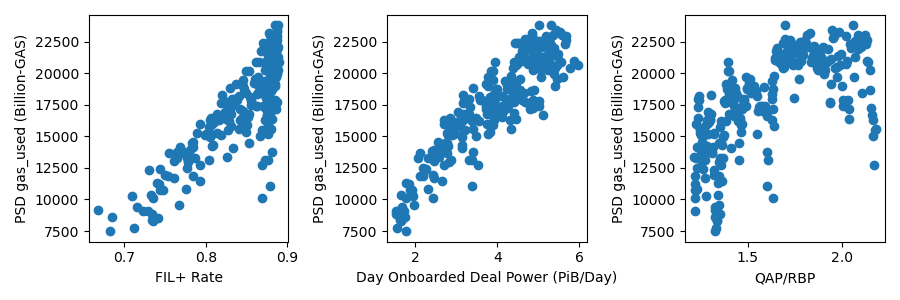

In [7]:
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.scatter(full_df['fpr'], full_df['publish_storage_deals_gas_used']*1e-9)
plt.xlabel('FIL+ Rate')
plt.ylabel('PSD gas_used (Billion-GAS)')

plt.subplot(1,3,2)
plt.scatter(full_df['day_onboarded_deal_power'], full_df['publish_storage_deals_gas_used']*1e-9)
plt.xlabel('Day Onboarded Deal Power (PiB/Day)')
plt.ylabel('PSD gas_used (Billion-GAS)')

plt.subplot(1,3,3)
plt.scatter(full_df['network_qa_rb_ratio'], full_df['publish_storage_deals_gas_used']*1e-9)
plt.xlabel('QAP/RBP')
plt.ylabel('PSD gas_used (Billion-GAS)')

plt.tight_layout()

<IPython.core.display.Javascript object>


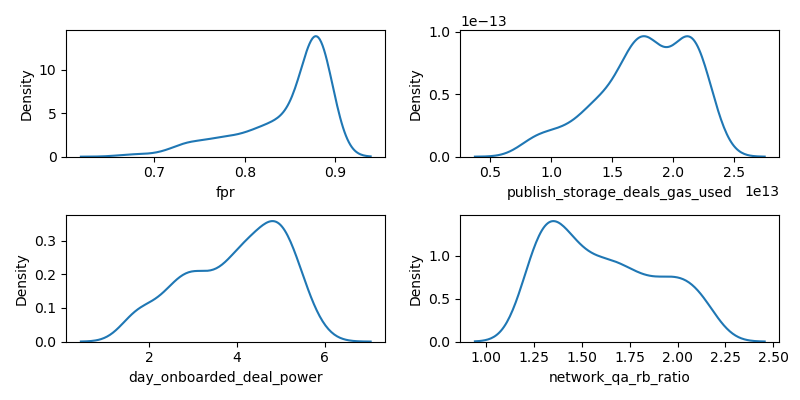

In [8]:
plt.figure(figsize=(8,4))

plt.subplot(2,2,1)
sns.kdeplot(full_df['fpr'])

plt.subplot(2,2,2)
sns.kdeplot(full_df['publish_storage_deals_gas_used'])

plt.subplot(2,2,3)
sns.kdeplot(full_df['day_onboarded_deal_power'])

plt.subplot(2,2,4)
sns.kdeplot(full_df['network_qa_rb_ratio'])

plt.tight_layout()

In [9]:
# Train PSD Model w/ GasX
psd_gasxmodel = gas_models.GasxGasModel('psd', log_after_scaler=True)
r = psd_gasxmodel.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.046775
Acceptance rate of Metropolis-Hastings is 0.4351
Acceptance rate of Metropolis-Hastings is 0.353225

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.34765
Normal GAS X(1,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: publish_storage_deals_gas_used      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 287.1372              
End Date: 189                                           AIC: -562.2744258837434                           
Number of observations: 189                             BIC: -542.8239437933856                           
Latent Variable                          Median             Mean               95% Credibility Interval 
====================

In [10]:
# Train PSD Model w/ GasX
psd_gasxmodel_nolog = gas_models.GasxGasModel('psd', log_after_scaler=False)
r = psd_gasxmodel_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.117925
Acceptance rate of Metropolis-Hastings is 0.19965
Acceptance rate of Metropolis-Hastings is 0.291775

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.291475
Normal GAS X(1,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: publish_storage_deals_gas_used      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -81.9412              
End Date: 189                                           AIC: 175.88235052358434                           
Number of observations: 189                             BIC: 195.3328326139422                            
Latent Variable                          Median             Mean               95% Credibility Interval 
==================

In [11]:
# Train PSD Model w/ ARIMAX
psd_arimax_model = gas_models.ArimaxGasModel('psd', log_after_scaler=True)
r = psd_arimax_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.04205
Acceptance rate of Metropolis-Hastings is 0.43315
Acceptance rate of Metropolis-Hastings is 0.348525

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.345875
Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: publish_storage_deals_gas_used      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 289.5447              
End Date: 189                                           AIC: -567.0893794620206                           
Number of observations: 189                             BIC: -547.6388973716628                           
Latent Variable                          Median             Mean               95% Credibility Interval 
===================

In [12]:
# Train PSD Model w/ ARIMAX
psd_arimax_model_nolog = gas_models.ArimaxGasModel('psd', log_after_scaler=False)
r = psd_arimax_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.108475
Acceptance rate of Metropolis-Hastings is 0.18845
Acceptance rate of Metropolis-Hastings is 0.2747

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2755375
Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: publish_storage_deals_gas_used      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -75.4635              
End Date: 189                                           AIC: 162.92709411921973                           
Number of observations: 189                             BIC: 182.3775762095776                            
Latent Variable                          Median             Mean               95% Credibility Interval 
===================

In [13]:
# using the forecast convenience function takes care of normalizing, unnormalizing, etc
y_pred_gasxpsd = psd_gasxmodel.forecast(test_df, num_mc)  
y_pred_gasxpsd_nolog = psd_gasxmodel_nolog.forecast(test_df, num_mc)  
y_pred_arimaxpsd = psd_arimax_model.forecast(test_df, num_mc) 
y_pred_arimaxpsd_nolog = psd_arimax_model_nolog.forecast(test_df, num_mc) 

<IPython.core.display.Javascript object>


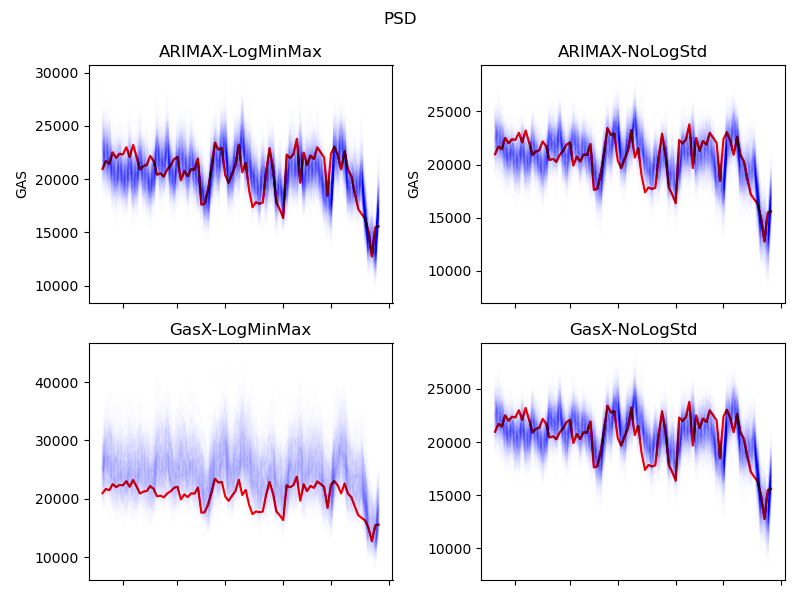

In [14]:
scale=1e-9
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,6))

axx = ax[0,0]
axx.plot(test_df['date'], test_df['publish_storage_deals_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], y_pred_arimaxpsd[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-LogMinMax')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[0,1]
axx.plot(test_df['date'], test_df['publish_storage_deals_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], y_pred_arimaxpsd_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-NoLogStd')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,0]
axx.plot(test_df['date'], test_df['publish_storage_deals_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], y_pred_gasxpsd[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-LogMinMax')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,1]
axx.plot(test_df['date'], test_df['publish_storage_deals_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], y_pred_arimaxpsd_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-NoLogStd')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

plt.suptitle('PSD')
plt.tight_layout()

In [15]:
# Train PrecommitX Model
precommitx_armiax_model = gas_models.ArimaxGasModel('precommitx', log_after_scaler=True)
r = precommitx_armiax_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.01515
Acceptance rate of Metropolis-Hastings is 0.36505

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3002125
Normal ARIMAX(1,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: precommitx_sector_gas_used          Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 251.6028              
End Date: 189                                           AIC: -473.20555834357634                          
Number of observations: 188                             BIC: -424.65892890112707                          
Latent Variable                          Median             Mean               95% Credibility Interval 
=======================

In [16]:
precommitx_armiax_model_nolog = gas_models.ArimaxGasModel('precommitx', log_after_scaler=False)
r = precommitx_armiax_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.020675
Acceptance rate of Metropolis-Hastings is 0.37075

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.355225
Normal ARIMAX(1,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: precommitx_sector_gas_used          Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -81.174               
End Date: 189                                           AIC: 188.34793119482154                           
Number of observations: 189                             BIC: 230.4906423905969                            
Latent Variable                          Median             Mean               95% Credibility Interval 
=======================

In [17]:
# Train PrecommitX Model
precommitx_gasx_model = gas_models.GasxGasModel('precommitx', log_after_scaler=True)
r = precommitx_gasx_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.015
Acceptance rate of Metropolis-Hastings is 0.35735

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.41185
Acceptance rate of Metropolis-Hastings is 0.1902
Acceptance rate of Metropolis-Hastings is 0.24715
Normal GAS X(1,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: precommitx_sector_gas_used          Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 247.3822              
End Date: 189                                           AIC: -464.7643345349326                           
Number of observations: 188                             BIC: -416.21770509248336                          
Latent Variable                  

In [18]:
precommitx_gasx_model_nolog = gas_models.GasxGasModel('precommitx', log_after_scaler=False)
r = precommitx_gasx_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.0054
Acceptance rate of Metropolis-Hastings is 0.3479

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.439075
Acceptance rate of Metropolis-Hastings is 0.27515
Normal GAS X(1,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: precommitx_sector_gas_used          Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -135.6075             
End Date: 189                                           AIC: 297.21507786289965                           
Number of observations: 189                             BIC: 339.357789058675                             
Latent Variable                          Median             Mean               95

In [19]:
ypred_armiax_precommitx = precommitx_armiax_model.forecast(test_df, num_mc)
ypred_armiax_precommitx_nolog = precommitx_armiax_model_nolog.forecast(test_df, num_mc)
# ypred_gasx_precommitx = precommitx_gasx_model.forecast(test_df, num_mc)
# ypred_gasx_precommitx_nolog = precommitx_gasx_model_nolog.forecast(test_df, num_mc)

<IPython.core.display.Javascript object>


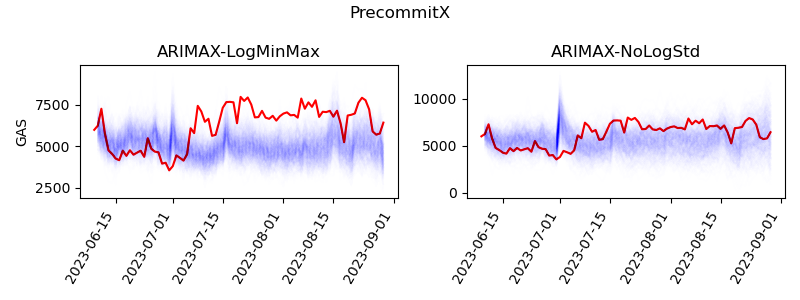

In [20]:
# NOTE: GasX model fails here for some reason?

scale=1e-9
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(8,3))

# axx = ax[0,0]
axx = ax[0]
axx.plot(test_df['date'], test_df['precommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'].iloc[1:], ypred_armiax_precommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-LogMinMax')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

# axx = ax[0,1]
axx = ax[1]
axx.plot(test_df['date'], test_df['precommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'].iloc[1:], ypred_armiax_precommitx_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-NoLogStd')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

# axx = ax[1,1]
# axx.plot(test_df['date'], test_df['precommitx_sector_gas_used']*scale, color='r', label='True')
# for ii in range(num_mc):
#     l = 'Forecast' if ii == 0 else None
#     axx.plot(test_df['date'], ypred_gasx_precommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
# axx.set_title('GasX-LogMinMax')
# axx.set_ylabel('GAS')
# axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

# axx = ax[1,0]
# axx.plot(test_df['date'], test_df['precommitx_sector_gas_used']*scale, color='r', label='True')
# for ii in range(num_mc):
#     l = 'Forecast' if ii == 0 else None
#     axx.plot(test_df['date'], ypred_gasx_precommitx_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
# axx.set_title('GasX-NoLogStd')
# axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

plt.suptitle('PrecommitX')
plt.tight_layout()

In [21]:
provecommitx_arimax_model = gas_models.ArimaxGasModel('provecommitx', log_after_scaler=True)
r = provecommitx_arimax_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.000125
Acceptance rate of Metropolis-Hastings is 0.047275
Acceptance rate of Metropolis-Hastings is 0.29085

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3063
Normal ARIMAX(2,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: provecommitx_sector_gas_used        Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 298.9682              
End Date: 189                                           AIC: -581.9364004037761                           
Number of observations: 188                             BIC: -556.0448647011366                           
Latent Variable                          Median             Mean               95% Credibility Interval 
====================

In [22]:
provecommitx_arimax_model_nolog = gas_models.ArimaxGasModel('provecommitx', log_after_scaler=False)
r = provecommitx_arimax_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.002425
Acceptance rate of Metropolis-Hastings is 0.15285
Acceptance rate of Metropolis-Hastings is 0.203675
Acceptance rate of Metropolis-Hastings is 0.258075

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2577875
Normal ARIMAX(1,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: provecommitx_sector_gas_used        Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -139.8156             
End Date: 189                                           AIC: 293.6311564025654                            
Number of observations: 189                             BIC: 316.3233855079829                            
Latent Variable                          Median             Mean       

In [23]:
provecommitx_gasx_model = gas_models.GasxGasModel('provecommitx', log_after_scaler=True)
r = provecommitx_gasx_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.001225
Acceptance rate of Metropolis-Hastings is 0.092725
Acceptance rate of Metropolis-Hastings is 0.254075

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.26465
Normal GAS X(2,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: provecommitx_sector_gas_used        Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 266.4122              
End Date: 189                                           AIC: -516.8243201674273                           
Number of observations: 188                             BIC: -490.93278446478774                          
Latent Variable                          Median             Mean               95% Credibility Interval 
==================

In [24]:
provecommitx_gasx_model_nolog = gas_models.GasxGasModel('provecommitx', log_after_scaler=False)
r = provecommitx_gasx_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.004375
Acceptance rate of Metropolis-Hastings is 0.207675
Acceptance rate of Metropolis-Hastings is 0.2748

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.276275
Normal GAS X(1,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: provecommitx_sector_gas_used        Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -177.8168             
End Date: 189                                           AIC: 369.6335555007497                            
Number of observations: 189                             BIC: 392.3257846061672                            
Latent Variable                          Median             Mean               95% Credibility Interval 
===================

In [25]:
ypred_armiax_provecommitx = provecommitx_arimax_model.forecast(test_df, num_mc)
ypred_gasx_provecommitx = provecommitx_gasx_model.forecast(test_df, num_mc)
ypred_armiax_provecommitx_nolog = provecommitx_arimax_model_nolog.forecast(test_df, num_mc)
ypred_gasx_provecommitx_nolog = provecommitx_gasx_model_nolog.forecast(test_df, num_mc)

<IPython.core.display.Javascript object>


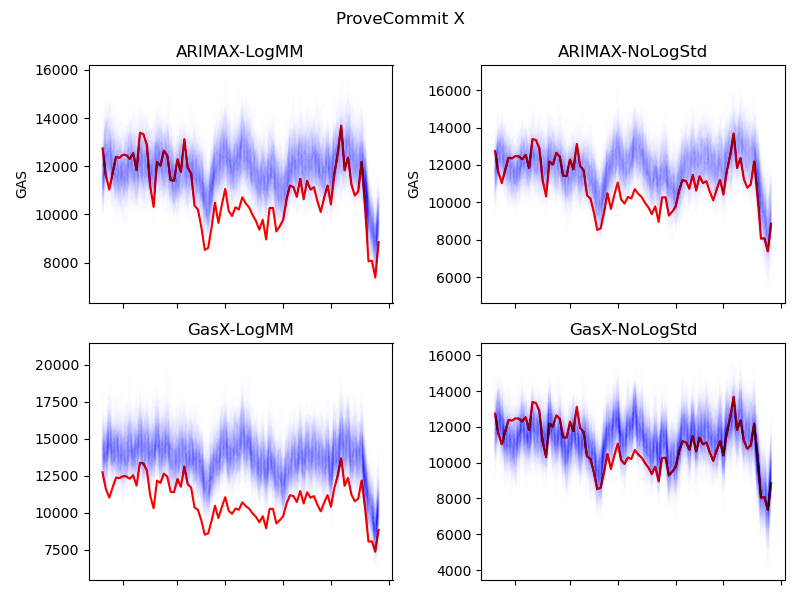

In [26]:
scale=1e-9
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,6))

axx = ax[0,0]
axx.plot(test_df['date'], test_df['provecommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_armiax_provecommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-LogMM')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[0,1]
axx.plot(test_df['date'], test_df['provecommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_armiax_provecommitx_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-NoLogStd')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,0]
axx.plot(test_df['date'], test_df['provecommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_gasx_provecommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-LogMM')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,1]
axx.plot(test_df['date'], test_df['provecommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_gasx_provecommitx_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-NoLogStd')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

plt.suptitle('ProveCommit X')
plt.tight_layout()

In [27]:
totalgas_arimax_model = gas_models.ArimaxGasModel('total', log_after_scaler=True)
r = totalgas_arimax_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.0225
Acceptance rate of Metropolis-Hastings is 0.35125

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.401125
Acceptance rate of Metropolis-Hastings is 0.259075
Normal ARIMAX(1,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 219.3953              
End Date: 189                                           AIC: -408.7905961522388                           
Number of observations: 188                             BIC: -360.24396670978956                          
Latent Variable                          Median             Mean               

In [28]:
totalgas_arimax_model_nolog = gas_models.ArimaxGasModel('total', log_after_scaler=False)
r = totalgas_arimax_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.0865
Acceptance rate of Metropolis-Hastings is 0.342325

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3485375
Normal ARIMAX(1,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: -157.0505             
End Date: 189                                           AIC: 344.10106523722163                           
Number of observations: 188                             BIC: 392.64769467967085                           
Latent Variable                          Median             Mean               95% Credibility Interval 
=======================

In [29]:
totalgas_gasx_model = gas_models.GasxGasModel('total', log_after_scaler=True)
r = totalgas_gasx_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.04305
Acceptance rate of Metropolis-Hastings is 0.407475
Acceptance rate of Metropolis-Hastings is 0.33765

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3651375
Normal GAS X(1,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 217.9351              
End Date: 189                                           AIC: -405.8702221703725                           
Number of observations: 188                             BIC: -357.32359272792326                          
Latent Variable                          Median             Mean             

In [30]:
totalgas_gasx_model_nolog = gas_models.GasxGasModel('total', log_after_scaler=False)
r = totalgas_gasx_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.0822
Acceptance rate of Metropolis-Hastings is 0.36875

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3518
Normal GAS X(1,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: -159.8503             
End Date: 189                                           AIC: 349.7005178177181                            
Number of observations: 188                             BIC: 398.24714726016737                           
Latent Variable                          Median             Mean               95% Credibility Interval 
===========================

In [31]:
ypred_armiax_total = totalgas_arimax_model.forecast(test_df, num_mc)
ypred_gasx_total = totalgas_gasx_model.forecast(test_df, num_mc)
ypred_armiax_total_nolog = totalgas_arimax_model_nolog.forecast(test_df, num_mc)
ypred_gasx_total_nolog = totalgas_gasx_model_nolog.forecast(test_df, num_mc)

<IPython.core.display.Javascript object>


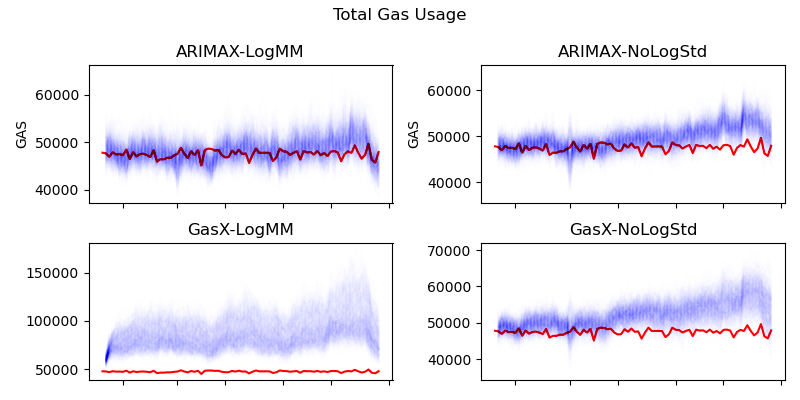

In [32]:
scale=1e-9
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,4))

axx = ax[0,0]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'].iloc[1:], ypred_armiax_total[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-LogMM')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[0,1]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'].iloc[1:], ypred_armiax_total_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-NoLogStd')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,0]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'].iloc[1:], ypred_gasx_total[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-LogMM')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,1]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'].iloc[1:], ypred_gasx_total_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-NoLogStd')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

plt.suptitle('Total Gas Usage')
plt.tight_layout()